# Run Attacks

## This attack simply inserts high-confidence 'positive' words based on queries from the test set to the model on sentences around that are negative. 

- This is a black box attack, assumes only access to confidence predictions and some preexising dataset of sentences, which may be benign.



## STEPS
1. Load all test sentences
2. Score them individually
3. Get top N (10?) benign, with high-confidence 
4. Generate attack tests (vary combinations of (`a=0,1,2` and `b=0,1,2`):
 - Adding `a` sentences before and `b` sentences after, chosen randomly from step3

In [14]:
import pickle
import os 
import pandas as pd 
from collections import Counter
import sys
import tensorflow as tf
from experiments import params
from data_utils_v2.data_helpers import genFeatures, loadVocabEmb,genPOSFeatures
from model.abuse_classifier import AbuseClassifier
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import trange

In [2]:
#define the model type and attention loss type we are testing

# MODEL_TYPE = "model_att=encoded_checkpoints"
MODEL_TYPE = "model_noatt_checkpoints"
ATTENTION_LOSS_TYPE = "encoded"
comm_or_sent = "sent"

#if model type is no attention, attention lambda should be 0
if MODEL_TYPE == "model_noatt_checkpoints":
    attention_lambda = 0.0
    ATTENTION_LOSS_TYPE = "none"
else:
    attention_lambda = 0.2

In [3]:
CLASSIFICATION_THRESHOLD = 0.3

In [4]:
flags = tf.app.flags

tf.flags.DEFINE_integer("embedding_dim", 300, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_integer("pos_vocab_size", 26, "Vocab size of POS tags")
tf.flags.DEFINE_integer("pos_embedding_dim", 25, "Dimensionality of pos tag embedding (default: 20)")
tf.flags.DEFINE_float("dropout_keep_prob", 1.0, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("attention_lambda", attention_lambda, "Supervised attention lambda (default: 0.05)")
tf.flags.DEFINE_string("attention_loss_type", ATTENTION_LOSS_TYPE, "loss function of attention")
tf.flags.DEFINE_float("l2_reg_lambda", 0.02, "L2 regularization lambda (default: 0.05)")
tf.flags.DEFINE_integer("hidden_size", 300, "Dimensionality of RNN cell (default: 300)")
tf.flags.DEFINE_integer("pos_hidden_size", 25, "Dimensionality of POS-RNN cell")
tf.flags.DEFINE_integer("attention_size", 20, "Dimensionality of attention scheme (default: 50)")
tf.flags.DEFINE_boolean("use_pos_flag", True, "use the sequence of POS tags")
# Training parameters -- evaluate_every should be 100
tf.flags.DEFINE_integer("batch_size", 32, "Batch Size (default: 32)")
tf.flags.DEFINE_integer("num_epochs", 60, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 50, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 500000, "Save model after this many steps (default: 100)")
# tf.flags.DEFINE_float("train_ratio", 1.0, "Ratio of training data")
# Misc Parameters
tf.flags.DEFINE_string("checkpoint", '', "model")
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

tf.app.flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [5]:
model_save_folder_name = MODEL_TYPE
print(f"Running model from {model_save_folder_name}")
model_folder_path = 'model_new'
checkpoint_dir = os.path.abspath(os.path.join(model_folder_path, model_save_folder_name))
model_path = os.path.join(checkpoint_dir, "best_model")

assert os.path.isdir(checkpoint_dir)

Running model from model_noatt_checkpoints


In [6]:
data_path = 'preprocessing/dump/'
dump_path = "preprocessing/dump/"
print(f"Using data from {data_path} and dump from {dump_path}")
assert os.path.isdir(data_path)
assert os.path.isdir(dump_path)

Using data from preprocessing/dump/ and dump from preprocessing/dump/


In [7]:
def load_vocab(dump_folder):
    vocabulary, pos_vocabulary, init_embed = loadVocabEmb(dump_folder)
    return vocabulary, pos_vocabulary, init_embed

In [8]:
# hyperparameter
max_sent_len = 100
unk = "<UNK>"
pad = "<PAD/>"
emb_dim = 300

def load_adv_exmples_and_evaluate(dump_folder, df_path):
    with open(os.path.join(dump_folder, "vocab.pkl"), "rb") as handle:
        vocabulary = pickle.load(handle)
    with open(os.path.join(dump_folder, "pos_vocab.pkl"), "rb") as handle:
        pos_vocabulary = pickle.load(handle)
        
    data_df = pd.read_pickle(df_path)
    
    sentences = data_df["tokenized"].to_list()

    labels = data_df["merged_label"].to_list()

    pos_sentences = data_df["pos_tags"].to_list()
    attention = data_df["attention"].to_list()

    # generate features & labels
    x, length, attention = genFeatures(sentences, attention, max_sent_len, vocabulary)
    pos, pos_length = genPOSFeatures(pos_sentences, max_sent_len, pos_vocabulary)
    y = np.array(labels)

    return x, length, attention, pos, pos_length, y, sentences

In [9]:
def get_predictions_adv_examples(model_path, dump_folder_path, adv_path, n, a, b, att):
    with open(os.path.join(dump_folder_path, "norm_init_embed.pkl"), "rb") as handle:
        init_embed = pickle.load(handle)

    
    if att:
        df_path = f"{adv_path}/adv_sent_mimicry_n{n}_a{a}_b{b}_ENCATT_df"
    else:
        df_path = f"{adv_path}/adv_sent_mimicry_n{n}_a{a}_b{b}_df"
        
    x_test, length_test, attention_test, pos_test, pos_length_test, y_test, sentences = \
        load_adv_exmples_and_evaluate(dump_folder_path, df_path)
    
    len_data = len(x_test)
    print(f"Running model on {len_data} ADV samples")

    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
            allow_soft_placement=FLAGS.allow_soft_placement,
            log_device_placement=FLAGS.log_device_placement
        )
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            model = AbuseClassifier(
                max_sequence_length=params.max_sent_len,
                num_classes=2,
                pos_vocab_size=FLAGS.pos_vocab_size,
                init_embed=init_embed,
                hidden_size=FLAGS.hidden_size,
                attention_size=FLAGS.attention_size,
                keep_prob=FLAGS.dropout_keep_prob,
                attention_lambda=FLAGS.attention_lambda,
                attention_loss_type=FLAGS.attention_loss_type,
                l2_reg_lambda=0.1,
                use_pos_flag=FLAGS.use_pos_flag)

            global_step = tf.Variable(0, name="global_step", trainable=False)
            saver = tf.train.Saver(tf.all_variables())
            # Initialize all variables
            sess.run(tf.initialize_all_variables())
            saver.restore(sess, model_path)

            dev_scores = []
            dev_confidences = []
            alphas = []
            pos = 0
            gap = 50
            while pos < len(x_test):
                x_batch = x_test[pos:pos + gap]
                pos_batch = pos_test[pos:pos + gap]
                y_batch = y_test[pos:pos + gap]
                length_batch = length_test[pos:pos + gap]
                pos_length_batch = pos_length_test[pos:pos + gap]
                pos += gap
                # score sentences
                feed_dict = {
                    model.input_word: x_batch,
                    model.input_pos: pos_batch,
                    model.input_y: y_batch,
                    model.sequence_length: length_batch,
                    model.dropout_keep_prob: 1.0
                }
                step, scores, alpha = sess.run([global_step, model.prob, model.alphas], feed_dict)
                dev_confidences = dev_confidences + list([[s[0],s[1]] for s in scores])
                dev_scores = dev_scores + list([s[0] for s in scores])
                alphas = alphas + list(alpha)
                
    return (dev_confidences, dev_scores, y_test, alphas), (x_test, length_test, attention_test, pos_test, pos_length_test, y_test, sentences)

# Evaluate Attack

In [11]:
def evaluate_attack(n, a, b, att):
    predictions_only_pos, _ = get_predictions_adv_examples(
        model_path, 
        dump_path,
        "adv_sentence_mimicry", 
        n, a, b, att
    )
    
    _, dev_scores_only_pos, _, _ = predictions_only_pos
    dev_scores_only_pos = np.array(dev_scores_only_pos)
    
    y_desired = np.array([[0] for _ in range(dev_scores_only_pos.shape[0])])
    
    y_pred = dev_scores_only_pos > CLASSIFICATION_THRESHOLD
    y_pred = y_pred.astype(int)
    
    
    # Metrics:
    attack_sucess_rate = accuracy_score(y_desired, y_pred)
    
    return attack_sucess_rate

In [15]:
top_n_options = [10, 50, 100]
ab_sent_options = [0, 1, 2, 3, 5]
opts = []
for n in top_n_options:
    for a in ab_sent_options:
        for b in ab_sent_options:
            for att in [True, False]:
                opts.append((n,a,b,att))

In [16]:
evaluation_results = {}
for i in trange(len(opts)):
    n, a, b, att = opts[i]
    evaluation_results[(n, a, b, att)] = evaluate_attack(n, a, b, att)

  0%|          | 0/150 [00:00<?, ?it/s]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  1%|          | 1/150 [00:02<06:48,  2.74s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  1%|▏         | 2/150 [00:05<06:46,  2.75s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  2%|▏         | 3/150 [00:08<06:59,  2.85s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  3%|▎         | 4/150 [00:11<06:49,  2.80s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  3%|▎         | 5/150 [00:13<06:46,  2.80s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  4%|▍         | 6/150 [00:16<06:45,  2.82s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  5%|▍         | 7/150 [00:20<07:29,  3.15s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  5%|▌         | 8/150 [00:23<07:11,  3.04s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  6%|▌         | 9/150 [00:26<07:01,  2.99s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  7%|▋         | 10/150 [00:29<06:51,  2.94s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  7%|▋         | 11/150 [00:32<06:48,  2.94s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  8%|▊         | 12/150 [00:34<06:40,  2.90s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  9%|▊         | 13/150 [00:37<06:36,  2.89s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


  9%|▉         | 14/150 [00:40<06:27,  2.85s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 10%|█         | 15/150 [00:43<06:21,  2.82s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 11%|█         | 16/150 [00:46<06:20,  2.84s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 11%|█▏        | 17/150 [00:49<06:17,  2.84s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 12%|█▏        | 18/150 [00:52<06:30,  2.96s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 13%|█▎        | 19/150 [00:55<06:27,  2.96s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 13%|█▎        | 20/150 [00:58<06:23,  2.95s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 14%|█▍        | 21/150 [01:00<06:12,  2.89s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 15%|█▍        | 22/150 [01:03<06:04,  2.85s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 15%|█▌        | 23/150 [01:06<05:59,  2.83s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 16%|█▌        | 24/150 [01:09<05:57,  2.84s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 17%|█▋        | 25/150 [01:12<05:53,  2.83s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 17%|█▋        | 26/150 [01:14<05:49,  2.82s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 18%|█▊        | 27/150 [01:17<05:47,  2.83s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 19%|█▊        | 28/150 [01:20<05:44,  2.83s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 19%|█▉        | 29/150 [01:23<05:44,  2.85s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 20%|██        | 30/150 [01:26<05:59,  3.00s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 21%|██        | 31/150 [01:29<05:50,  2.94s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 21%|██▏       | 32/150 [01:32<05:42,  2.90s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 22%|██▏       | 33/150 [01:35<05:35,  2.87s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 23%|██▎       | 34/150 [01:38<05:30,  2.85s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 23%|██▎       | 35/150 [01:40<05:27,  2.85s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 24%|██▍       | 36/150 [01:43<05:24,  2.84s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 25%|██▍       | 37/150 [01:46<05:22,  2.86s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 25%|██▌       | 38/150 [01:49<05:19,  2.85s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 26%|██▌       | 39/150 [01:52<05:20,  2.89s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 27%|██▋       | 40/150 [01:55<05:24,  2.95s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 27%|██▋       | 41/150 [01:58<05:21,  2.95s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 28%|██▊       | 42/150 [02:01<05:23,  2.99s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 29%|██▊       | 43/150 [02:04<05:14,  2.94s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 29%|██▉       | 44/150 [02:07<05:08,  2.91s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 30%|███       | 45/150 [02:10<05:04,  2.90s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 31%|███       | 46/150 [02:13<05:02,  2.90s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 31%|███▏      | 47/150 [02:15<04:59,  2.90s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 32%|███▏      | 48/150 [02:18<04:54,  2.89s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 33%|███▎      | 49/150 [02:21<04:52,  2.90s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 33%|███▎      | 50/150 [02:24<04:50,  2.91s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 34%|███▍      | 51/150 [02:27<04:39,  2.82s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 35%|███▍      | 52/150 [02:29<04:32,  2.78s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 35%|███▌      | 53/150 [02:32<04:30,  2.79s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 36%|███▌      | 54/150 [02:35<04:23,  2.75s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 37%|███▋      | 55/150 [02:38<04:20,  2.74s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 37%|███▋      | 56/150 [02:40<04:16,  2.73s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 38%|███▊      | 57/150 [02:43<04:14,  2.73s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 39%|███▊      | 58/150 [02:46<04:14,  2.76s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 39%|███▉      | 59/150 [02:49<04:12,  2.78s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 40%|████      | 60/150 [02:52<04:11,  2.80s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 41%|████      | 61/150 [02:54<04:04,  2.75s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 41%|████▏     | 62/150 [02:57<03:59,  2.72s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 42%|████▏     | 63/150 [03:00<03:56,  2.71s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 43%|████▎     | 64/150 [03:02<03:58,  2.77s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 43%|████▎     | 65/150 [03:05<03:55,  2.77s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 44%|████▍     | 66/150 [03:08<03:52,  2.77s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 45%|████▍     | 67/150 [03:11<03:50,  2.77s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 45%|████▌     | 68/150 [03:14<03:47,  2.77s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 46%|████▌     | 69/150 [03:16<03:48,  2.82s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 47%|████▋     | 70/150 [03:19<03:46,  2.83s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 47%|████▋     | 71/150 [03:22<03:41,  2.80s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 48%|████▊     | 72/150 [03:25<03:36,  2.78s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 49%|████▊     | 73/150 [03:28<03:33,  2.77s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 49%|████▉     | 74/150 [03:30<03:31,  2.78s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 50%|█████     | 75/150 [03:33<03:27,  2.77s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 51%|█████     | 76/150 [03:36<03:24,  2.77s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 51%|█████▏    | 77/150 [03:39<03:22,  2.78s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 52%|█████▏    | 78/150 [03:41<03:20,  2.78s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 53%|█████▎    | 79/150 [03:44<03:19,  2.81s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 53%|█████▎    | 80/150 [03:47<03:20,  2.86s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 54%|█████▍    | 81/150 [03:50<03:15,  2.83s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 55%|█████▍    | 82/150 [03:53<03:10,  2.81s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 55%|█████▌    | 83/150 [03:56<03:07,  2.79s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 56%|█████▌    | 84/150 [03:58<03:03,  2.78s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 57%|█████▋    | 85/150 [04:01<03:01,  2.79s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 57%|█████▋    | 86/150 [04:04<03:01,  2.83s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 58%|█████▊    | 87/150 [04:07<02:58,  2.83s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 59%|█████▊    | 88/150 [04:10<02:55,  2.83s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 59%|█████▉    | 89/150 [04:13<02:53,  2.85s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 60%|██████    | 90/150 [04:15<02:51,  2.86s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 61%|██████    | 91/150 [04:18<02:49,  2.88s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 61%|██████▏   | 92/150 [04:21<02:45,  2.85s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 62%|██████▏   | 93/150 [04:24<02:43,  2.87s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 63%|██████▎   | 94/150 [04:27<02:44,  2.93s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 63%|██████▎   | 95/150 [04:30<02:40,  2.92s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 64%|██████▍   | 96/150 [04:33<02:37,  2.92s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 65%|██████▍   | 97/150 [04:36<02:34,  2.91s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 65%|██████▌   | 98/150 [04:39<02:31,  2.91s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 66%|██████▌   | 99/150 [04:42<02:28,  2.91s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 67%|██████▋   | 100/150 [04:45<02:25,  2.91s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 67%|██████▋   | 101/150 [04:47<02:18,  2.83s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 68%|██████▊   | 102/150 [04:50<02:14,  2.81s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 69%|██████▊   | 103/150 [04:53<02:09,  2.76s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 69%|██████▉   | 104/150 [04:55<02:06,  2.74s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 70%|███████   | 105/150 [04:58<02:03,  2.73s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 71%|███████   | 106/150 [05:01<02:00,  2.73s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 71%|███████▏  | 107/150 [05:04<01:57,  2.74s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 72%|███████▏  | 108/150 [05:06<01:56,  2.78s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 73%|███████▎  | 109/150 [05:09<01:53,  2.78s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['A', ',', '^', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 73%|███████▎  | 110/150 [05:12<01:52,  2.81s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 74%|███████▍  | 111/150 [05:15<01:47,  2.76s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 75%|███████▍  | 112/150 [05:17<01:43,  2.73s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 75%|███████▌  | 113/150 [05:20<01:42,  2.76s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 76%|███████▌  | 114/150 [05:23<01:39,  2.76s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 77%|███████▋  | 115/150 [05:26<01:36,  2.75s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 77%|███████▋  | 116/150 [05:28<01:33,  2.76s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 78%|███████▊  | 117/150 [05:31<01:31,  2.77s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 79%|███████▊  | 118/150 [05:34<01:30,  2.82s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 79%|███████▉  | 119/150 [05:37<01:27,  2.82s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 80%|████████  | 120/150 [05:40<01:24,  2.82s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 81%|████████  | 121/150 [05:43<01:20,  2.79s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 81%|████████▏ | 122/150 [05:45<01:17,  2.77s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 82%|████████▏ | 123/150 [05:48<01:14,  2.77s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 83%|████████▎ | 124/150 [05:51<01:12,  2.80s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 83%|████████▎ | 125/150 [05:54<01:09,  2.79s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 84%|████████▍ | 126/150 [05:57<01:07,  2.80s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 85%|████████▍ | 127/150 [05:59<01:04,  2.81s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 85%|████████▌ | 128/150 [06:02<01:01,  2.81s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 86%|████████▌ | 129/150 [06:05<00:59,  2.84s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 87%|████████▋ | 130/150 [06:08<00:57,  2.86s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 87%|████████▋ | 131/150 [06:11<00:53,  2.83s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 88%|████████▊ | 132/150 [06:14<00:50,  2.81s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 89%|████████▊ | 133/150 [06:16<00:47,  2.80s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 89%|████████▉ | 134/150 [06:19<00:44,  2.79s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 90%|█████████ | 135/150 [06:22<00:42,  2.83s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 91%|█████████ | 136/150 [06:25<00:39,  2.83s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 91%|█████████▏| 137/150 [06:28<00:36,  2.84s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 92%|█████████▏| 138/150 [06:31<00:34,  2.84s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 93%|█████████▎| 139/150 [06:33<00:31,  2.86s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 93%|█████████▎| 140/150 [06:36<00:28,  2.87s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 94%|█████████▍| 141/150 [06:39<00:25,  2.88s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 95%|█████████▍| 142/150 [06:42<00:22,  2.86s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 95%|█████████▌| 143/150 [06:45<00:20,  2.86s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 96%|█████████▌| 144/150 [06:48<00:17,  2.85s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 97%|█████████▋| 145/150 [06:51<00:14,  2.85s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 97%|█████████▋| 146/150 [06:54<00:11,  2.88s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 98%|█████████▊| 147/150 [06:56<00:08,  2.87s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 99%|█████████▊| 148/150 [06:59<00:05,  2.88s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


 99%|█████████▉| 149/150 [07:02<00:02,  2.91s/it]

padded sent: (616, 100)
feature shape: (616, 100)
padded pos sentences: (616, 100)
debug padded_pos_sentences: ['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']
pos feature shape: (616, 100)
Running model on 616 ADV samples
No supervised attention.
INFO:tensorflow:Restoring parameters from /Users/pablokvitca/Projects/Academic/NEU/CY7790/toxicity_filter_attacks/model_new/model_noatt_checkpoints/best_model


100%|██████████| 150/150 [07:05<00:00,  2.84s/it]


In [17]:
evaluation_results

{(10, 0, 0, True): 0.38636363636363635,
 (10, 0, 0, False): 0.38636363636363635,
 (10, 0, 1, True): 0.387987012987013,
 (10, 0, 1, False): 0.38636363636363635,
 (10, 0, 2, True): 0.38636363636363635,
 (10, 0, 2, False): 0.38636363636363635,
 (10, 0, 3, True): 0.387987012987013,
 (10, 0, 3, False): 0.38636363636363635,
 (10, 0, 5, True): 0.38636363636363635,
 (10, 0, 5, False): 0.38636363636363635,
 (10, 1, 0, True): 0.5275974025974026,
 (10, 1, 0, False): 0.5146103896103896,
 (10, 1, 1, True): 0.5275974025974026,
 (10, 1, 1, False): 0.5324675324675324,
 (10, 1, 2, True): 0.525974025974026,
 (10, 1, 2, False): 0.5211038961038961,
 (10, 1, 3, True): 0.5308441558441559,
 (10, 1, 3, False): 0.512987012987013,
 (10, 1, 5, True): 0.5373376623376623,
 (10, 1, 5, False): 0.5097402597402597,
 (10, 2, 0, True): 0.5616883116883117,
 (10, 2, 0, False): 0.5487012987012987,
 (10, 2, 1, True): 0.5616883116883117,
 (10, 2, 1, False): 0.5503246753246753,
 (10, 2, 2, True): 0.5681818181818182,
 (10, 2, 

In [19]:
import matplotlib.pyplot as plt

PLOTTING 25 ATT points
PLOTTING 25 NOATT points
PLOTTING 25 ATT points
PLOTTING 25 NOATT points
PLOTTING 25 ATT points
PLOTTING 25 NOATT points


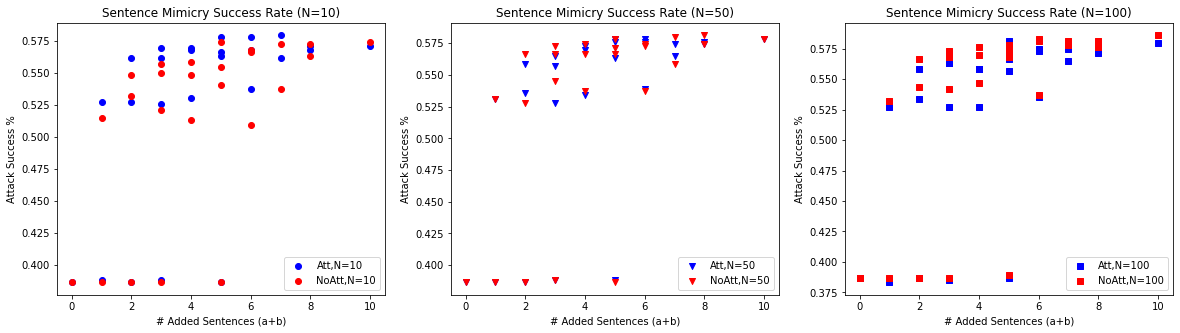

In [86]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
for n, marker, ax in zip(top_n_options, ["o", "v", "s"], axs):
    xs_att, ys_att = [], []
    xs_noatt, ys_noatt = [], []
    for a in ab_sent_options:
        for b in ab_sent_options:
            x_att, y_att = a + b, evaluation_results[n, a, b, True]
            xs_att.append(x_att), ys_att.append(y_att)
            
            x_noatt, y_noatt = a + b, evaluation_results[n, a, b, False]
            xs_noatt.append(x_noatt), ys_noatt.append(y_noatt)
            
    print(f"PLOTTING {len(xs_att)} ATT points")
    print(f"PLOTTING {len(xs_noatt)} NOATT points")
    
    ax.scatter(xs_att, ys_att, color="blue", marker=marker, label=f"Att,N={n}")
    ax.scatter(xs_noatt, ys_noatt, color="red", marker=marker, label=f"NoAtt,N={n}")
    
    ax.set_xlabel("# Added Sentences (a+b)")
    ax.set_ylabel("Attack Success %")
    
    ax.legend()
    ax.set_title(f"Sentence Mimicry Success Rate (N={n})")
    
plt.savefig("mimicry_sentence_summed_added.png")
plt.show()

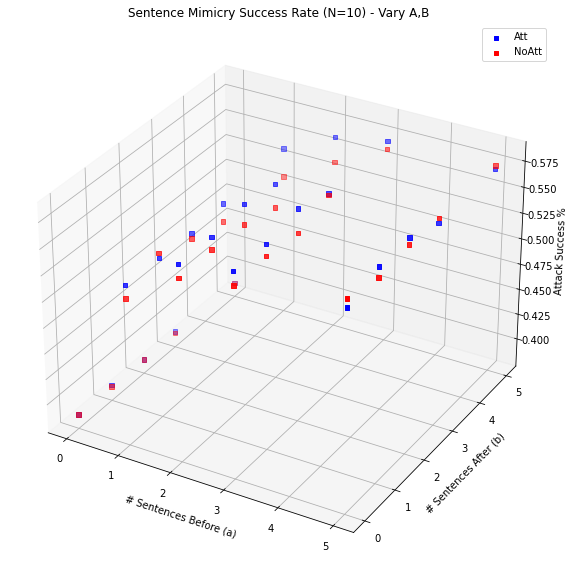

In [85]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
n = 10

xs_att, ys_att, zs_att = [], [], []
xs_noatt, ys_noatt, zs_noatt = [], [], []
for a in ab_sent_options:
    for b in ab_sent_options:
        x_att, y_att, z_att = a, b, evaluation_results[n, a, b, True]
        xs_att.append(x_att), ys_att.append(y_att), zs_att.append(z_att)

        x_noatt, y_noatt, z_noatt = a, b, evaluation_results[n, a, b, False]
        xs_noatt.append(x_noatt), ys_noatt.append(y_noatt), zs_noatt.append(z_noatt)

ax.scatter(xs_att, ys_att, zs_att, color="blue", marker=marker, label=f"Att")
ax.scatter(xs_noatt, ys_noatt, zs_noatt, color="red", marker=marker, label=f"NoAtt")

ax.set_xlabel("# Sentences Before (a)")
ax.set_ylabel("# Sentences After (b)")
ax.set_zlabel("Attack Success %")

ax.legend()
ax.set_title(f"Sentence Mimicry Success Rate (N={n}) - Vary A,B")

plt.savefig("mimicry_sentence_ab3d.png")
plt.show()

/Users/pablokvitca/anaconda3/envs/toxicity_filter_attacks_36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/pablokvitca/anaconda3/envs/toxicity_filter_attacks_36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
No handles with labels found to put in legend.
/Users/pablokvitca/anaconda3/envs/toxicity_filter_attacks_36/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/pablokvitca/anaconda3/envs/toxicity_filter_attacks_36/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Sentence Mimicry (N=10) - No Attention')

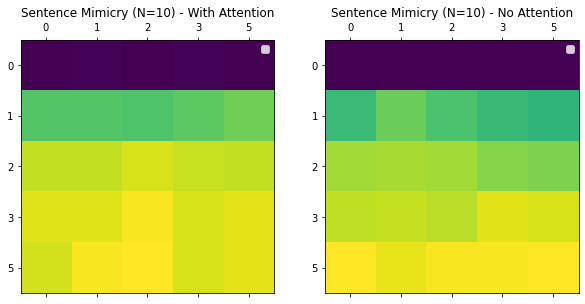

In [53]:
fig, (ax_att, ax_noatt) = plt.subplots(1, 2, figsize=(10,10))

n = 10

mat_att = np.zeros((len(ab_sent_options), len(ab_sent_options)))
mat_noatt = np.zeros((len(ab_sent_options), len(ab_sent_options)))

for i, a in enumerate(ab_sent_options):
    for j, b in enumerate(ab_sent_options):
        x_att, y_att, z_att = a, b, evaluation_results[n, a, b, True]
        mat_att[i,j] = z_att

        x_noatt, y_noatt, z_noatt = a, b, evaluation_results[n, a, b, False]
        mat_noatt[i,j] = z_noatt

ax_att.matshow(mat_att, interpolation ='nearest')
ax_att.set_xticklabels(['']+list(map(str, ab_sent_options)))
ax_att.set_yticklabels(['']+list(map(str, ab_sent_options)))
ax_att.legend()
ax_att.set_title(f"Sentence Mimicry (N={n}) - With Attention")

ax_noatt.matshow(mat_noatt, interpolation ='nearest')
ax_noatt.set_xticklabels(['']+list(map(str, ab_sent_options)))
ax_noatt.set_yticklabels(['']+list(map(str, ab_sent_options)))
ax_noatt.legend()
ax_noatt.set_title(f"Sentence Mimicry (N={n}) - No Attention")

In [68]:
evaluation_results_noatt = {(k[0], k[1], k[2]):v for k,v in evaluation_results.items() if k[3] == False}
evaluation_results_att = {(k[0], k[1], k[2]):v for k,v in evaluation_results.items() if k[3] == True}

In [69]:
evaluation_results_noatt

{(10, 0, 0): 0.38636363636363635,
 (10, 0, 1): 0.38636363636363635,
 (10, 0, 2): 0.38636363636363635,
 (10, 0, 3): 0.38636363636363635,
 (10, 0, 5): 0.38636363636363635,
 (10, 1, 0): 0.5146103896103896,
 (10, 1, 1): 0.5324675324675324,
 (10, 1, 2): 0.5211038961038961,
 (10, 1, 3): 0.512987012987013,
 (10, 1, 5): 0.5097402597402597,
 (10, 2, 0): 0.5487012987012987,
 (10, 2, 1): 0.5503246753246753,
 (10, 2, 2): 0.5487012987012987,
 (10, 2, 3): 0.5405844155844156,
 (10, 2, 5): 0.5373376623376623,
 (10, 3, 0): 0.5568181818181818,
 (10, 3, 1): 0.5584415584415584,
 (10, 3, 2): 0.5551948051948052,
 (10, 3, 3): 0.5665584415584416,
 (10, 3, 5): 0.5633116883116883,
 (10, 5, 0): 0.5746753246753247,
 (10, 5, 1): 0.5681818181818182,
 (10, 5, 2): 0.573051948051948,
 (10, 5, 3): 0.573051948051948,
 (10, 5, 5): 0.5746753246753247,
 (50, 0, 0): 0.38636363636363635,
 (50, 0, 1): 0.38636363636363635,
 (50, 0, 2): 0.38636363636363635,
 (50, 0, 3): 0.387987012987013,
 (50, 0, 5): 0.38636363636363635,
 (50,

In [70]:
attack_params = list(evaluation_results_noatt.keys())
attack_scores = list(evaluation_results_noatt.values())
_, sorted_by_success_params = tuple(zip(*sorted(zip(attack_scores, attack_params), key=lambda x: x[0])))

In [71]:
x = np.arange(0, len(sorted_by_success_params))
y_noatt = np.array([evaluation_results_noatt[(n,a,b)] for n, a, b in sorted_by_success_params])
y_att = np.array([evaluation_results_att[(n,a,b)] for n, a, b in sorted_by_success_params])

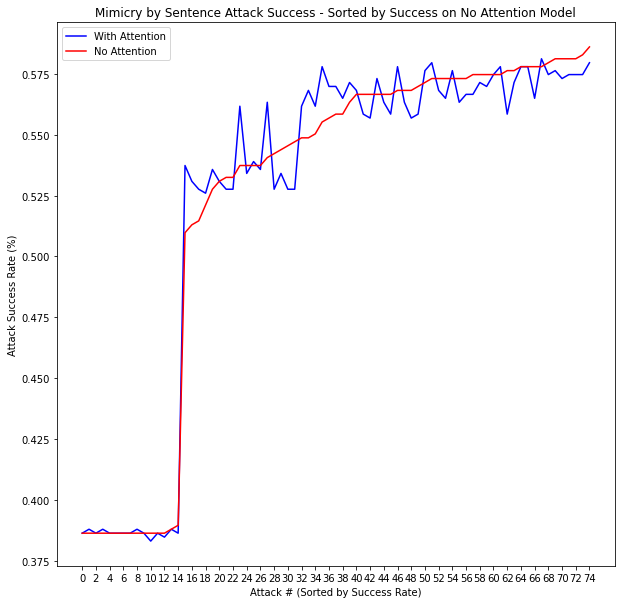

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(x, y_att, color="blue", label="With Attention")
ax.plot(x, y_noatt, color="red", label="No Attention")

ax.set_xlabel("Attack # (Sorted by Success Rate)")
ax.xaxis.set_ticks(np.arange(0, len(sorted_by_success_params)+1, 2))
ax.set_ylabel("Attack Success Rate (%)")

plt.legend()
plt.title("Mimicry by Sentence Attack Success - Sorted by Success on No Attention Model")
plt.savefig("mimicry_sentence_sorted_comparison.png")
plt.show()

In [87]:
best_params = sorted_by_success_params[-1]
print(f"BEST PARAMS: N={best_params[0]}, A={best_params[1]} B={best_params[2]}")
print("SUCCESS RATE, NOATT:", evaluation_results_noatt[best_params])
print("SUCCESS RATE, ATT:", evaluation_results_att[best_params])

BEST PARAMS: N=100, A=5 B=5
SUCCESS RATE, NOATT: 0.586038961038961
SUCCESS RATE, ATT: 0.5795454545454546


In [92]:
no_attack_params = sorted_by_success_params[0]
print(f"NO ATTACK PARAMS: N={no_attack_params[0]}, A={no_attack_params[1]} B={no_attack_params[2]}")
print("SUCCESS RATE, NOATT:", evaluation_results_noatt[no_attack_params])
print("SUCCESS RATE, ATT:", evaluation_results_att[no_attack_params])

NO ATTACK PARAMS: N=10, A=0 B=0
SUCCESS RATE, NOATT: 0.38636363636363635
SUCCESS RATE, ATT: 0.38636363636363635


In [89]:
worst_params = sorted_by_success_params[1]
print(f"WORST PARAMS: N={worst_params[0]}, A={worst_params[1]} B={worst_params[2]}")
print("SUCCESS RATE, NOATT:", evaluation_results_noatt[worst_params])
print("SUCCESS RATE, ATT:", evaluation_results_att[worst_params])

WORST PARAMS: N=10, A=0 B=1
SUCCESS RATE, NOATT: 0.38636363636363635
SUCCESS RATE, ATT: 0.387987012987013
